In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Patch
import torch
import dgl
import random
import io


from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D,IPythonConsole
from PIL import Image

from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load

from omtra.constants import charge_map, lig_atom_type_map

from omtra.models.ligand_encoder.vq import LigandVQVAE

from omtra.tasks.register import task_name_to_class
from omtra.eval.system import SampledSystem
from omtra.data.graph.utils import get_upper_edge_mask

from omtra.constants import *

/net/galaxy/home/koes/ltoft/.conda/envs/omtra/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from omtra.data.condensed_atom_typing import CondensedAtomTyper
from omtra.eval.system import SampledSystem

cfg = quick_load.load_cfg(overrides=['task_group=pharmit5050_cond_a'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
pharmit_train_dataset = train_dataset.datasets['pharmit']
g = pharmit_train_dataset[('denovo_ligand_condensed', 0)]

# Add a fake atom
feat_data = {}
for feat in g.nodes["lig"].data.keys():  
    if 'cond_a_' in feat:
        feat_data[feat] = torch.tensor([390])
    elif 'a_' in feat:
        feat_data[feat] = torch.tensor([11])
    elif 'x_' in feat:
        feat_data[feat] = torch.tensor([[0.0,0.0,0.0]]) 
    else:
        feat_data[feat] = torch.tensor([0])

g.add_nodes(1, data=feat_data, ntype="lig")

cond_a_typer = CondensedAtomTyper(True)
sampled_system = SampledSystem(
                g=g.clone(),
                fake_atoms=True,
                cond_a_typer=cond_a_typer,
            )


⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [53]:
for feat in g.nodes["lig"].data.keys():
    if not torch.equal(sampled_system.g.nodes["lig"].data[feat], g.nodes["lig"].data[feat]):
        print(f"{feat} not equal")


In [4]:
cfg = quick_load.load_cfg(overrides=['task_group=no_protein'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
pharmit_train_dataset = train_dataset.datasets['pharmit']
g = pharmit_train_dataset[('denovo_ligand', 0)]
g.nodes["lig"].data.keys()

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


dict_keys(['x_1_true', 'a_1_true', 'c_1_true', 'x_0', 'a_0', 'c_0'])

In [1]:
import torch
from collections import Counter

train_data = torch.load('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/pharmit_ligand_properties/outputs/count_lig_feats/train_unique_feat_tuples.pt')
val_data = torch.load('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/pharmit_ligand_properties/outputs/count_lig_feats/val_unique_feat_tuples.pt')

combined = dict(Counter(train_data) + Counter(val_data))


/tmp/ipykernel_1537515/1925485113.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/pharmit_liga

In [3]:
import pickle

with open('/net/galaxy/home/koes/ltoft/OMTRA/omtra/constants/pharmit_condensed_atom_types.pkl', 'wb') as f:
    pickle.dump(combined, f)

## Embedding Vector Visualization

In [3]:
def move_feats_to_t1(task_name: str, g: dgl.DGLHeteroGraph, t: str = '0'):
    task = task_name_to_class(task_name)
    for m in task.modalities_present:

        num_entries = g.num_nodes(m.entity_name) if m.is_node else g.num_edges(m.entity_name)
        if num_entries == 0:
            continue

        data_src = g.nodes if m.is_node else g.edges
        dk = m.data_key
        en = m.entity_name

        if t == '0' and m in task.modalities_fixed:
            data_to_copy = data_src[en].data[f'{dk}_1_true']
        else:
            data_to_copy = data_src[en].data[f'{dk}_{t}']

        data_src[en].data[f'{dk}_1'] = data_to_copy

    return g

def dgl_to_rdkit(g):
    """ Converts one DGL molecule to RDKit ligand """
    g = move_feats_to_t1('denovo_ligand', g, '1_true')
    rdkit_ligand = SampledSystem(g).get_rdkit_ligand()
    return rdkit_ligand

In [4]:
def display_ligands(pharmit_dataset, indices, n_cols=3, img_size=(800,800)):

    mol_images = []
    n_mols = len(indices)

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()
        

        for idx, a in enumerate(g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist()):
            options.atomLabels[idx] = f"{lig_atom_type_map[a]}, {idx}"


        drawer.DrawMolecule(ligand)
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Display
    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [5]:
# Get pharmit datases
cfg = quick_load.load_cfg(overrides=['task_group=no_protein'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
pharmit_train_dataset = train_dataset.datasets['pharmit']

val_dataset = datamodule.load_dataset("val")
pharmit_val_dataset = val_dataset.datasets['pharmit']

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [6]:
def get_codebook_indices(model, g):
    z_e, mask = model.encoder(g)  # Encoder output
    mask = mask.cpu().numpy().flatten().tolist()
    _, z_d, codebook_indices, _, _ = model.vq_vae(z_e)
    codebook_indices = codebook_indices.cpu().numpy().flatten().tolist()
    return codebook_indices, z_d, mask


def display_ligand_embeddings(model, pharmit_dataset, index_to_color, n_mols=1, indices=None, n_cols=3, img_size=(600,600)):
    
    if indices is None:
        indices = [random.randint(0, len(pharmit_dataset)-1) for _ in range(n_mols)]
        print(f"Using random indices: {indices}")
    else:
        n_mols = len(indices)
    
    model.eval()

    mol_images = []

    # Collect the codebook indices actually used in these molecules
    used_codebook_indices = set()

    mask_indicator = {False:'', True:'**'}

    for i in indices:
        if model.use_extra_feats:
            g = pharmit_dataset[('denovo_ligand_extra_feats', i)]
        else:
            g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)
        codebook_indices, _, mask = get_codebook_indices(model, g)
        used_codebook_indices.update(codebook_indices)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)

        # Create atom color map
        atom_colors = {idx: [index_to_color[val]] for idx, val in enumerate(codebook_indices)}
        highlight_radii = {idx: 0.3 for idx in atom_colors}

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()
        
        for idx, (a, c) in enumerate(zip(
            g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist(),
            g.nodes['lig'].data['c_1_true'].cpu().numpy().flatten().tolist())):
            if charge_map[c] == 0:
                options.atomLabels[idx] = f"{lig_atom_type_map[a]}{mask_indicator[mask[idx]]}"
            else:
                options.atomLabels[idx] = f"{lig_atom_type_map[a]} {charge_map[c]}{mask_indicator[mask[idx]]}"

        drawer.DrawMoleculeWithHighlights(
            ligand, '', atom_colors, {}, highlight_radii, {}
        )
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Create legend patches for used codebook indices
    legend_patches = [
        Patch(color=index_to_color[idx], label=f'Codebook {idx}')
        for idx in sorted(used_codebook_indices)
    ]
    print("number of codebook vectors used:", len(used_codebook_indices))
    # Display
    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
    plt.tight_layout()
    plt.show()


In [7]:
import matplotlib.pyplot as plt
import colorsys

def lighten_color(color, amount=1.3):
    """
    Lightens the given RGBA color by multiplying the lightness (L in HLS) by amount.
    """
    r, g, b, a = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = min(1, l * amount)  # increase lightness but max 1
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, a)

## Extra Feats
Use extra atom features:
- impl_H: number of implicit hydrogens
- aro: aromatic?
- hyb: hybridization
- ring: in a ring?
- chiral: chiral center?

number of codebook vectors used: 35


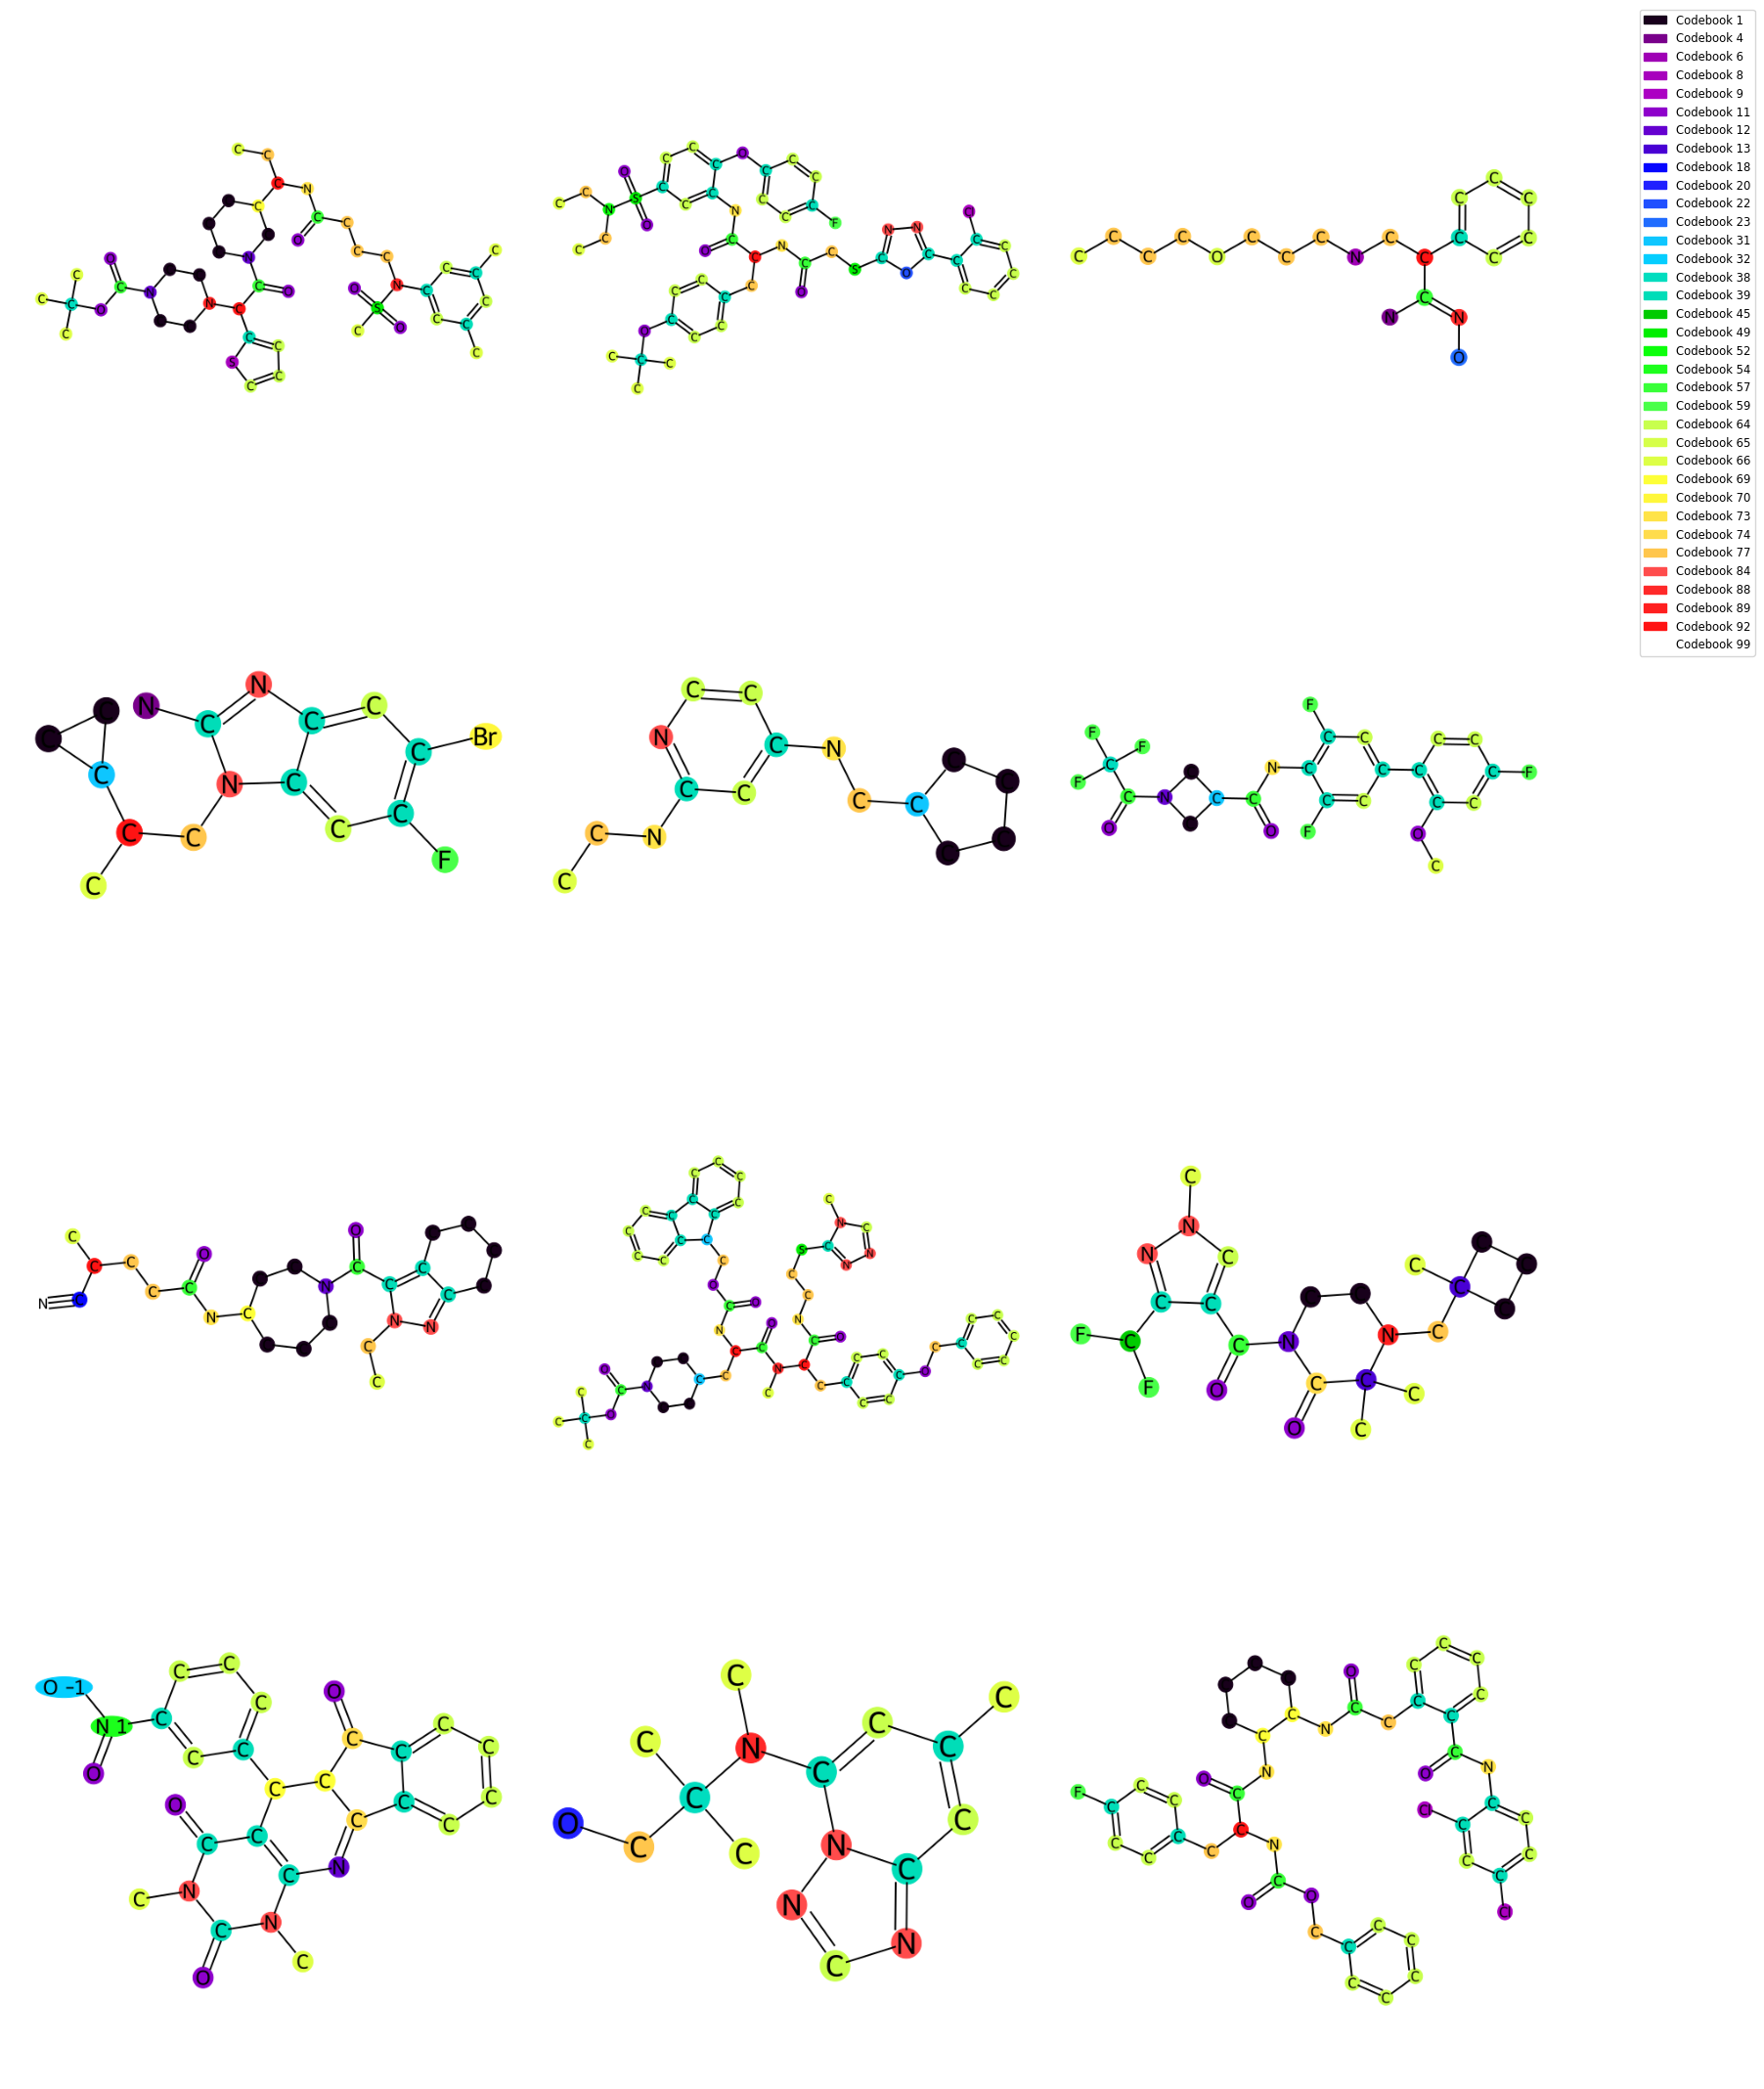

In [8]:
# Use extra features
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-06-30/EMA_extra_feats_2025-06-30_14-13-416262/checkpoints/last.ckpt"
model = LigandVQVAE.load_from_checkpoint(checkpoint)

num_embeddings = model.vq_vae.num_embeddings
colormap = matplotlib.colormaps.get_cmap('nipy_spectral')

# Generate lightened colormap
index_to_color = {
    i: lighten_color(colormap(i / (num_embeddings - 1))[:4], amount=1.3)
    for i in range(num_embeddings)
}

display_ligand_embeddings(model, pharmit_val_dataset, index_to_color, indices=[4455608, 2443760, 3514035, 3498938, 2873876, 2638608, 2032191, 2359807, 2577854, 4243698, 3502419, 2784527])

### Baseline
Don't use extra features

number of codebook vectors used: 15


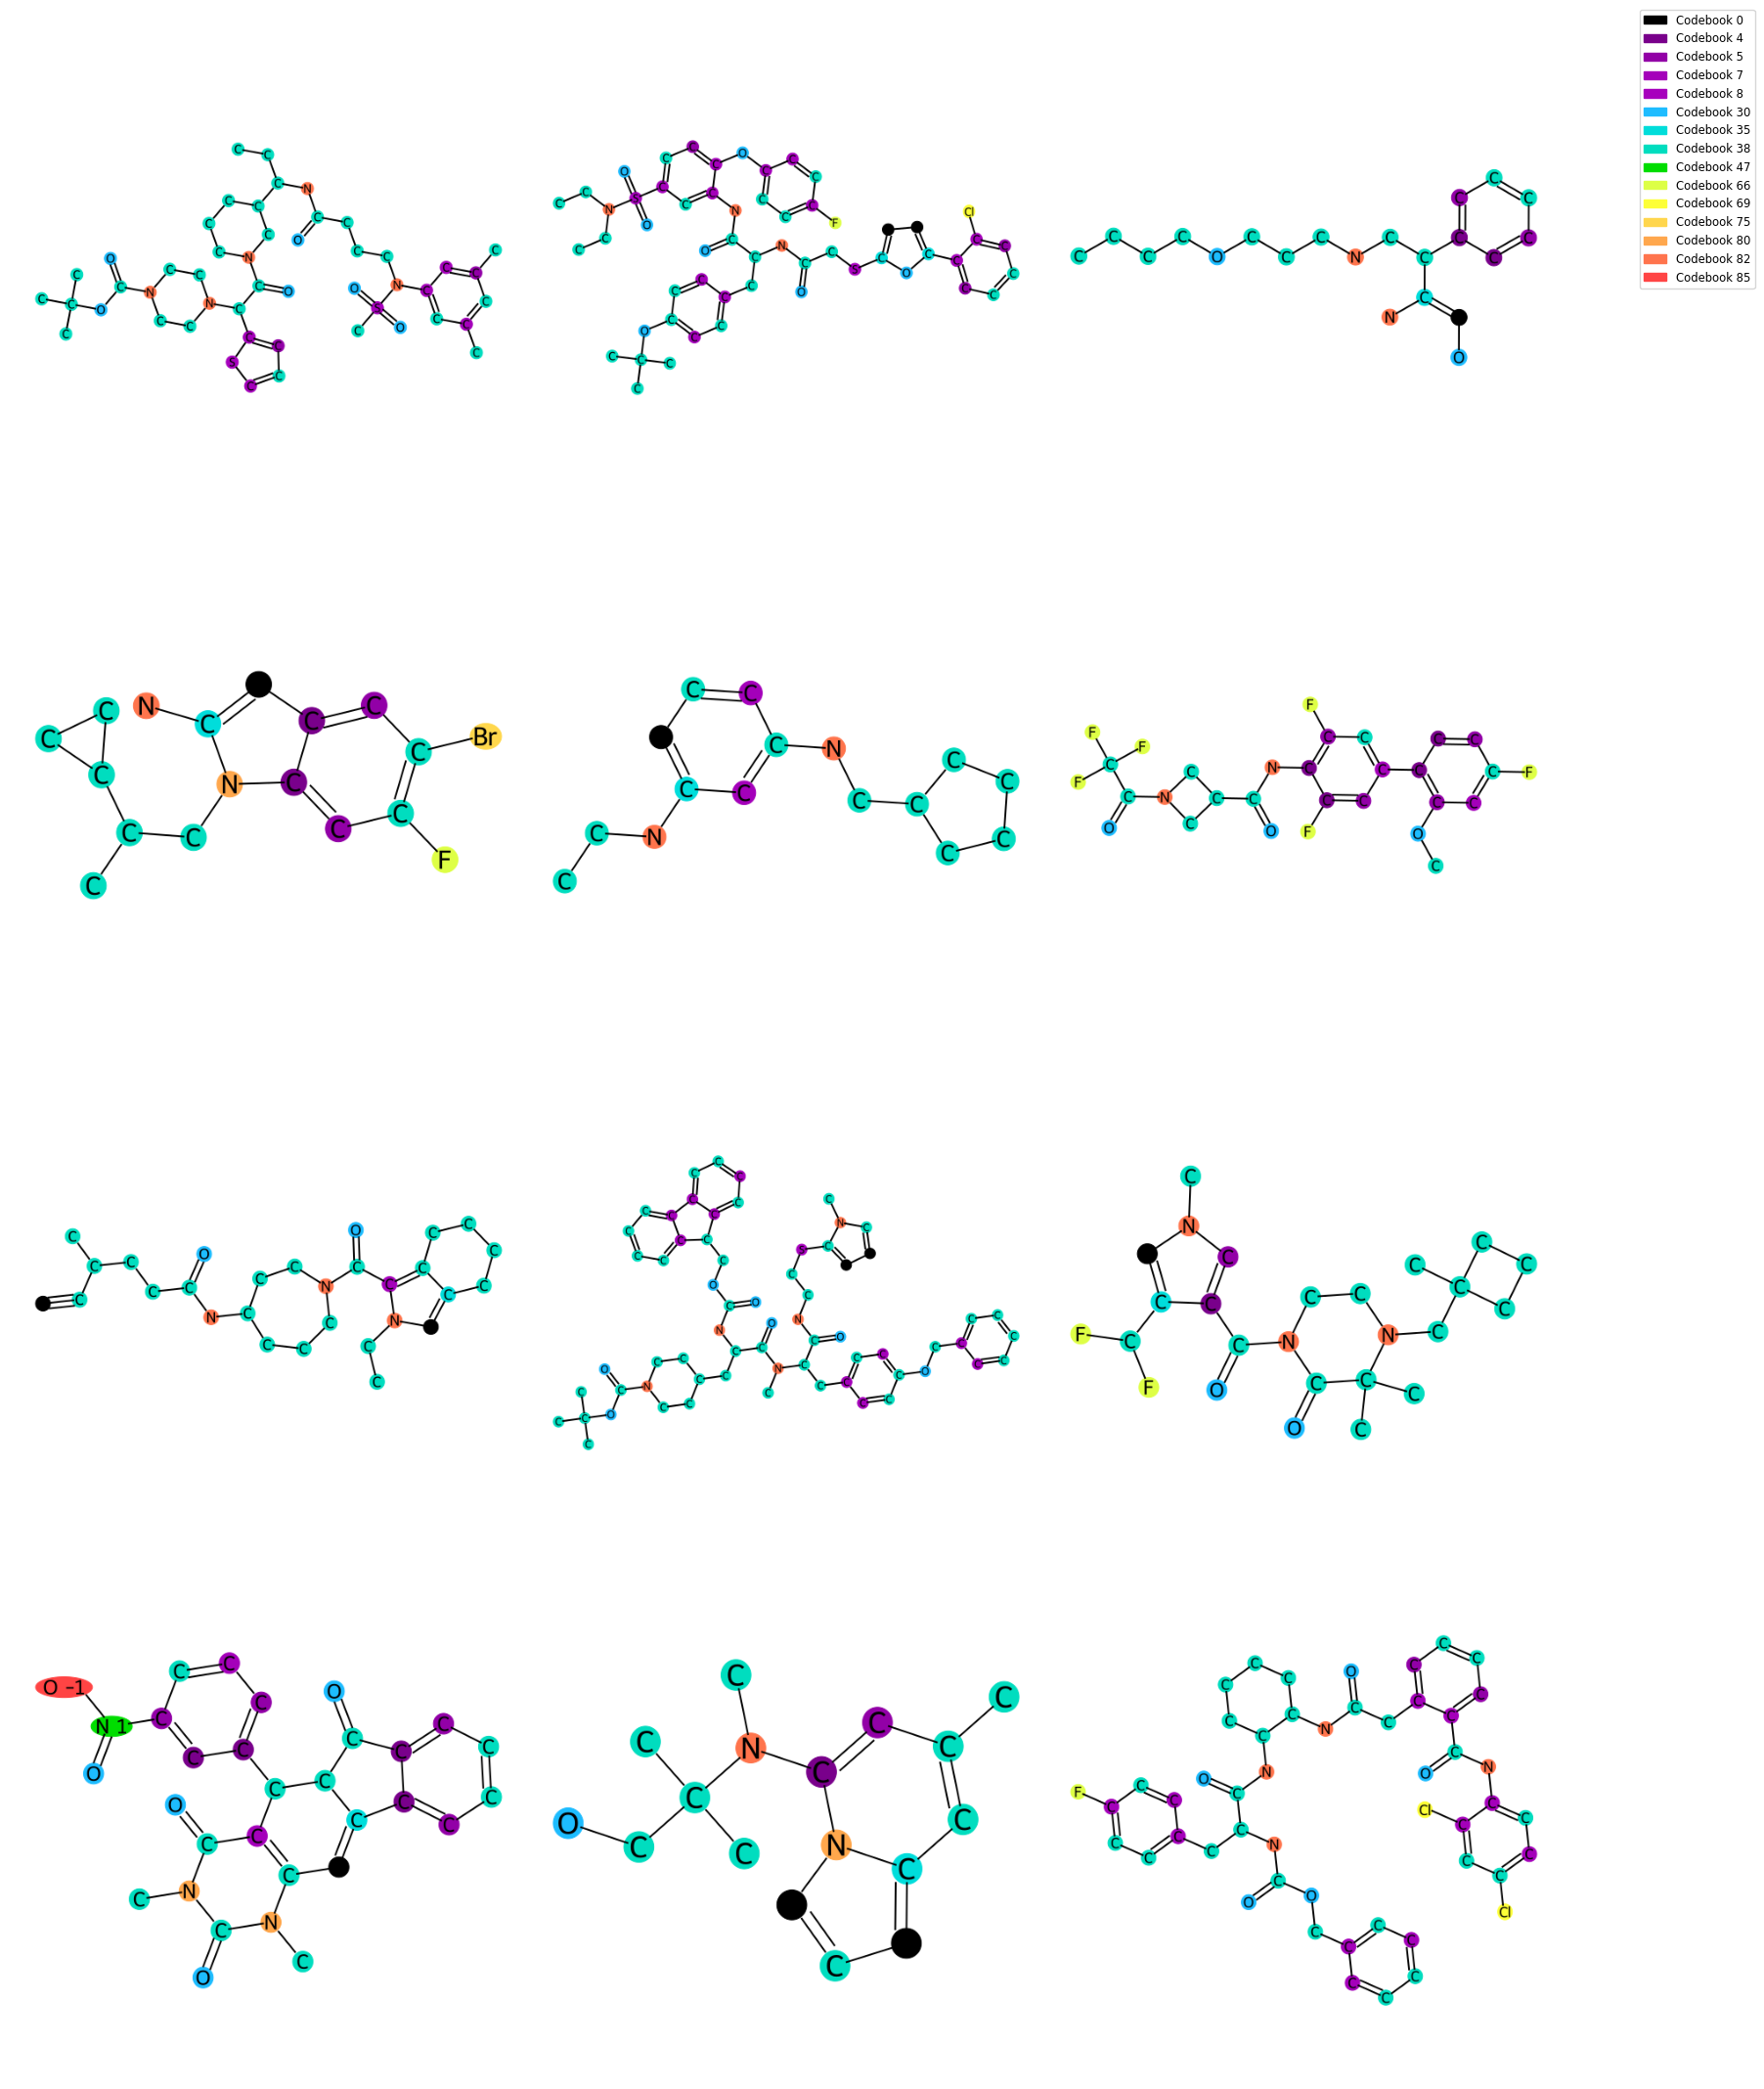

In [9]:
# BASELINE:
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-06-30/EMA_baseline_2025-06-30_14-13-407448/checkpoints/last.ckpt"

model = LigandVQVAE.load_from_checkpoint(checkpoint)

display_ligand_embeddings(model, pharmit_val_dataset, index_to_color, indices=[4455608, 2443760, 3514035, 3498938, 2873876, 2638608, 2032191, 2359807, 2577854, 4243698, 3502419, 2784527])

# Display molecules with mispredictions

In [30]:
def predicted(model, g):
    z_e, mask = model.encoder(g)  # Encoder output
    mask = mask.cpu().numpy().flatten().tolist()
    _, z_d, _, _, _ = model.vq_vae(z_e)
    logits = model.decoder(g, z_d)

    pred = {}
    for feat, logit in logits.items():
        pred[feat] = torch.argmax(logit, dim=1)

    return pred


feat_map = {'atom_type': {idx: type for idx, type in enumerate(lig_atom_type_map)}, 
            'atom_charge': {idx: charge for idx, charge in enumerate(charge_map)},
            'bond_order': {0: 'none',
                  1: 'single',
                  2: 'double',
                  3: 'triple'},
            'impl_H': {idx: idx for idx in range(max_impl_H)},
            'aro': {0: 'no', 1: 'yes'},
            'hyb': {idx: hyb for idx, hyb in enumerate(hybridization_map)},
            'ring': {0: 'no', 1: 'yes'},
            'chiral': {0: 'no', 1: 'yes'}
            }

def display_performance(model, pharmit_dataset, n_mols=1, indices=None, n_cols=3, use_bond_order=False, img_size=(600, 600)):
    
    error_color_map = {
        'atom_type':  (0.9, 0.0, 0.9),   # bright magenta / fuchsia
        'atom_charge': (0.05533745098039211, 0.7748441352053032, 1.0, 1.0),  # bright blue
        'bond_order':  (1.0, 0.12330960784313727, 0.12330960784313727, 1.0),  # bright red
        'aro':        (0.6763135294117653, 0.0, 0.7629980392156862, 1.0),   # bright green
        'impl_H': (0.1267100000000001, 0.1267100000000001, 1.0, 1.0),
        'hyb':     (0.9999999999999999, 0.7749019607843137, 0.30000000000000016, 1.0),   # bright orange
        'ring':       (0.9912465438100144, 1.0, 0.2166903921568628, 1.0),   # bright purple
        'chiral':     (0.0, 0.7969892156862745, 0.0, 1.0),   # bright teal / cyan
        'hyb':        (0.9999999999999999, 0.6541176470588235, 0.30000000000000016, 1.0),   # bright mustard / yellowish
    }

    def molecule_has_prediction_error(pred, truth):
        for feat in truth:
            if feat in pred and not torch.equal(pred[feat].cpu(), truth[feat].cpu()):
                pred = predicted(model, g)
                return True
        return False

    model.eval()
    mol_images = []
    indices = []

    # If indices=None, collect molecules with at least 1 atom prediction error
    while len(indices) < n_mols:
        i = random.randint(0, len(pharmit_dataset) - 1)
        g = pharmit_dataset[('denovo_ligand_extra_feats', i)]

        pred = predicted(model, g)
        truth = {}

        if use_bond_order:
            upper_edge_mask = get_upper_edge_mask(g, 'lig_to_lig')
            truth['bond_order'] = g.edges['lig_to_lig'].data['e_1_true'][upper_edge_mask]

            # remove 0 bonds
            non_zero_indices = (truth['bond_order'] != 0).nonzero(as_tuple=True)[0]
            truth['bond_order'] = truth['bond_order'][non_zero_indices]
            pred['bond_order'] = pred['bond_order'][non_zero_indices]

        else:
            truth['atom_type'] = g.nodes['lig'].data['a_1_true']
            truth['atom_charge'] = g.nodes['lig'].data['c_1_true']

            if model.use_extra_feats:
                for feat in ['aro', 'impl_H', 'ring', 'chiral', 'hyb']:
                    truth[feat] = g.nodes['lig'].data.get(f'{feat}_1_true')

        if molecule_has_prediction_error(pred, truth):
            print("Molecule #", i)
            indices.append(i)

            ligand = dgl_to_rdkit(g)
            AllChem.Compute2DCoords(ligand)

            # Draw the molecule
            drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
            options = drawer.drawOptions()
            options.useBWAtomPalette()

            atom_colors = {}
            bond_colors = {}
            highlight_radii = {}

            # Get highlight colors
            for feat, color in error_color_map.items():
                if feat == 'bond_order' and not use_bond_order:
                    continue
                if feat not in pred or feat not in truth:
                    continue
                mismatch = (pred[feat].cpu() != truth[feat].cpu()).tolist()
                for idx, is_wrong in enumerate(mismatch):
                    if is_wrong:
                        if feat == 'bond_order':
                            bond = ligand.GetBondWithIdx(idx)

                            print(f"wrong {feat} at ({bond.GetBeginAtomIdx()}, {bond.GetEndAtomIdx()}). predicted: {feat_map[feat][int(pred[feat][idx])]}")
                            bond_colors[idx] = [color]
                        else:
                            print(f"wrong {feat} at {idx}, truth: {feat_map[feat][int(truth[feat][idx])]}, predicted: {feat_map[feat][int(pred[feat][idx])]}")
                            prev_color = atom_colors.get(idx, [(0.0, 0.0, 0.0)])[0]
                            blended_color = (
                                min(1.0, prev_color[0] + color[0]),
                                min(1.0, prev_color[1] + color[1]),
                                min(1.0, prev_color[2] + color[2]),
                            )
                            atom_colors[idx] = [blended_color]
                            highlight_radii[idx] = 0.4                        
        
            for idx, (a, c) in enumerate(zip(
                g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist(),
                g.nodes['lig'].data['c_1_true'].cpu().numpy().flatten().tolist())):
                if charge_map[c] == 0:
                    options.atomLabels[idx] = f"{idx} {lig_atom_type_map[a]}"
                else:
                    options.atomLabels[idx] = f"{idx} {lig_atom_type_map[a]}{charge_map[c]}"

            drawer.DrawMoleculeWithHighlights(
                ligand, '', atom_colors, bond_colors, highlight_radii, {}
            )
            drawer.FinishDrawing()
            img_bytes = drawer.GetDrawingText()
            img = Image.open(io.BytesIO(img_bytes))
            mol_images.append(img)
            print('––––––––––––––––––––––––––––')
    
    print("\nIndices:", indices)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Legend
    error_legend = [
        Patch(color=color, label=f'{feat}')
        for feat, color in error_color_map.items()
    ]

    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.legend(handles=error_legend, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


using extra feats
using extra feats
using extra feats
Molecule # 4875953
wrong atom_type at 19, truth: Br, predicted: Cl
––––––––––––––––––––––––––––
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
Molecule # 4092530
wrong atom_type at 40, truth: Br, predicted: Cl
––––––––––––––––––––––––––––
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
Molecule # 4875909
wrong atom_type at 19, truth: Br, predicted: Cl
––––––––––––––––––––––––––––
using extra feats
using extra feats
Molecule # 4883782
wrong atom_type at 16, truth: P, predicted: Cl
––––––––––––––––––––––––––––
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
using extra feats
Molecule # 3349985
wrong atom_type at 14, truth: Br, predicted: Cl
––––––––––

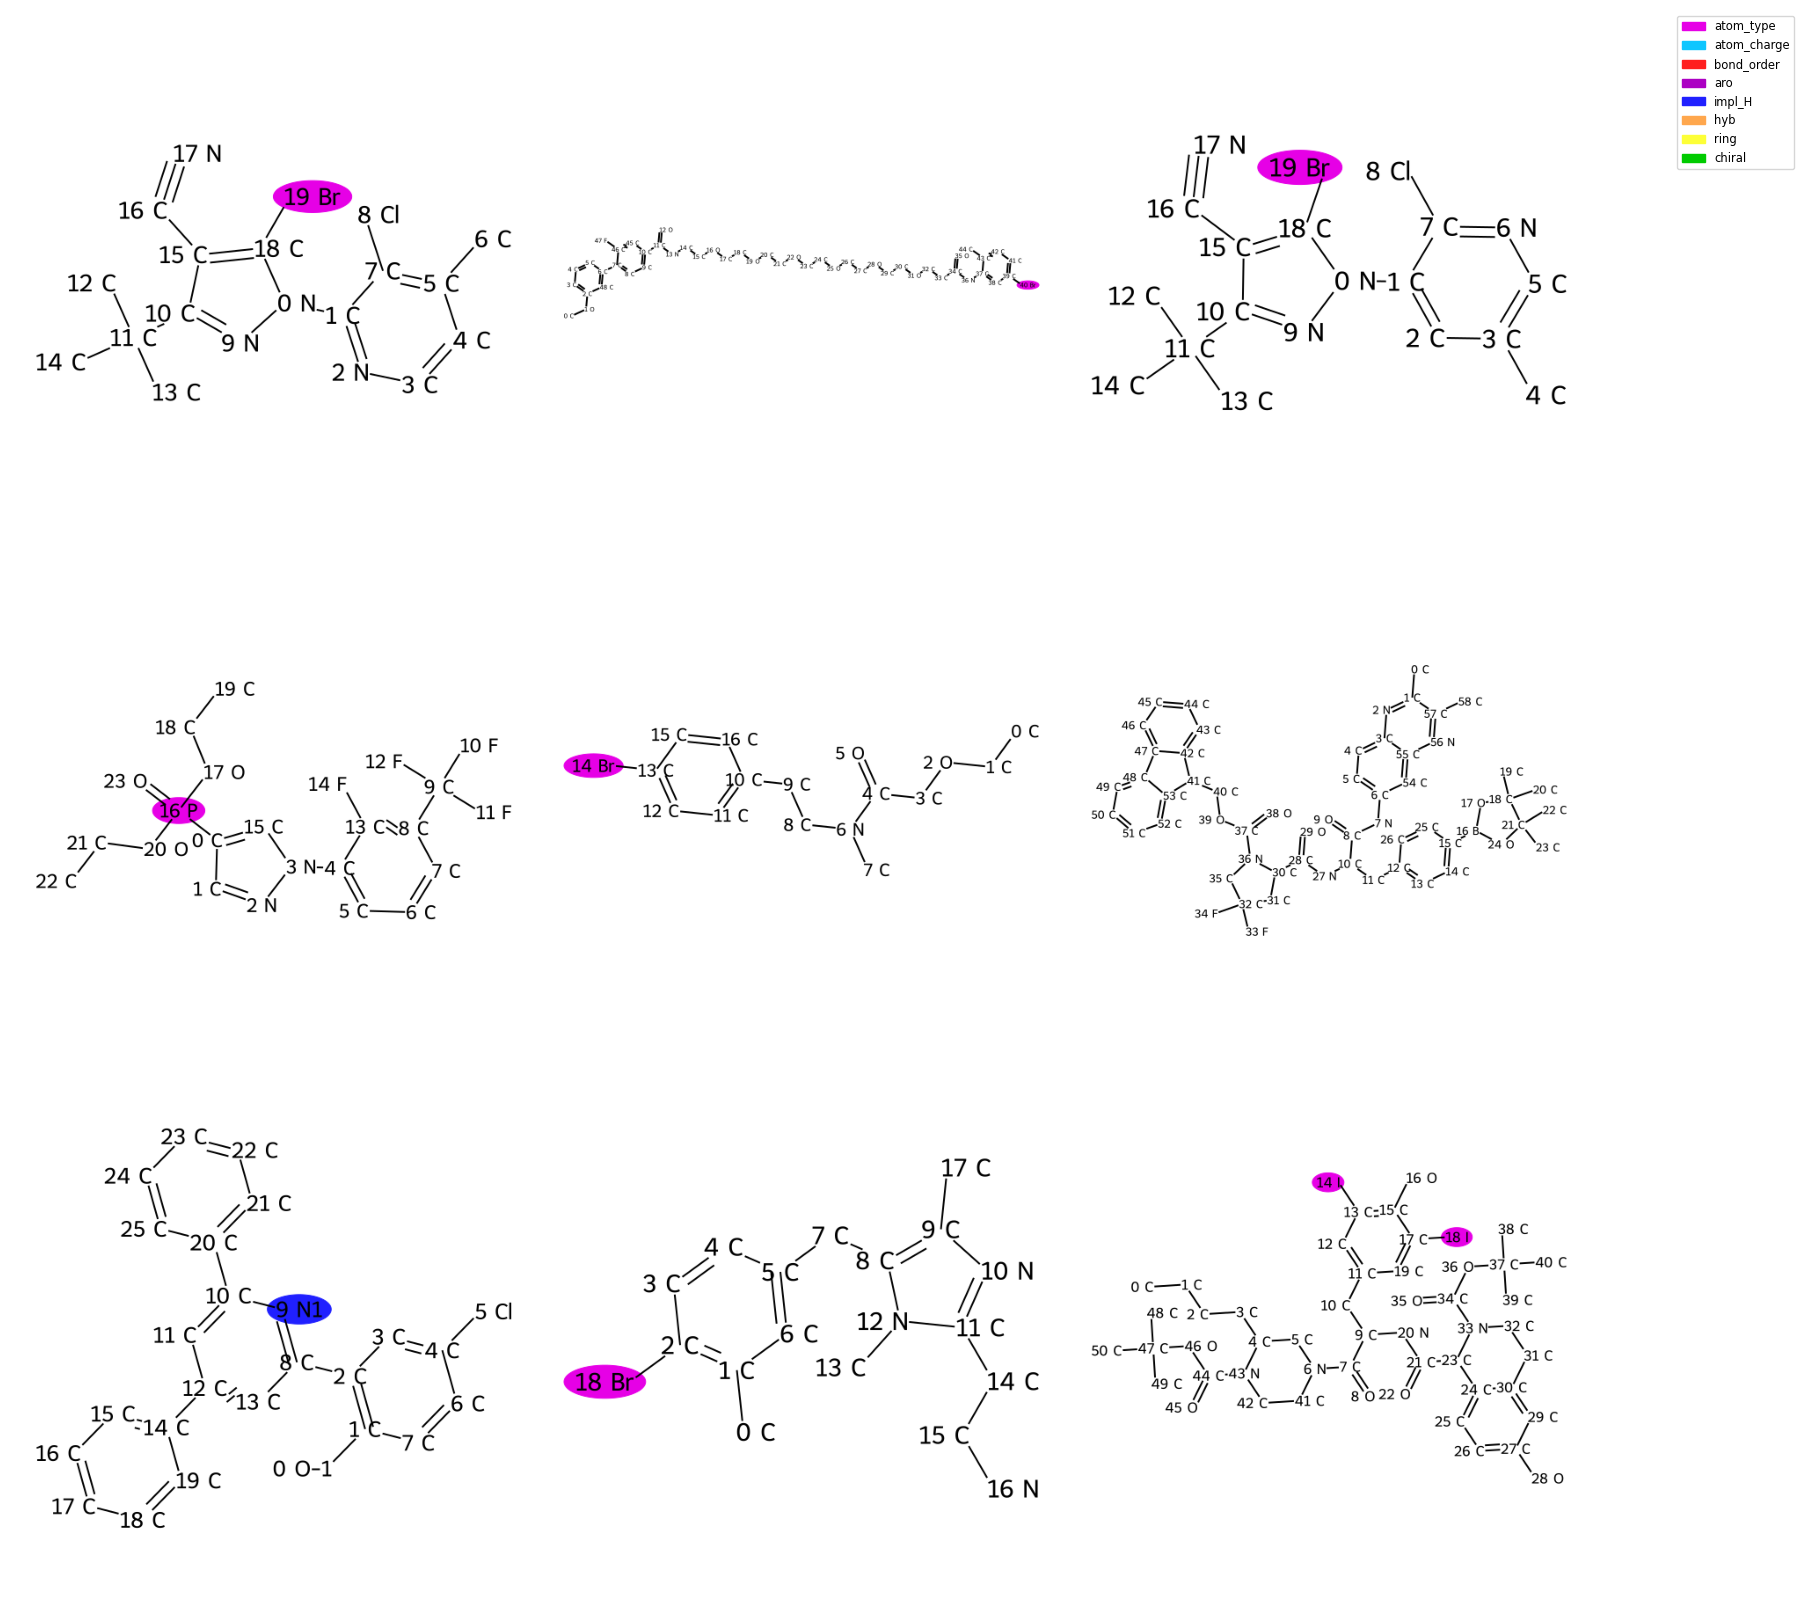

In [25]:
# Ignore wrongly predicted bond orders
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-07-08/e_nonzero_loss_2025-07-08_10-21-078175/checkpoints/last.ckpt"

model = LigandVQVAE.load_from_checkpoint(checkpoint)

display_performance(model, pharmit_val_dataset, n_mols=9, use_bond_order=False)

Molecule # 107091
wrong bond_order at (18, 19). predicted: single
wrong bond_order at (18, 23). predicted: double
wrong bond_order at (21, 22). predicted: double
wrong bond_order at (22, 23). predicted: single
––––––––––––––––––––––––––––
Molecule # 5055647
wrong bond_order at (13, 14). predicted: single
wrong bond_order at (14, 15). predicted: double
wrong bond_order at (17, 18). predicted: double
––––––––––––––––––––––––––––
Molecule # 3812361
wrong bond_order at (24, 25). predicted: single
wrong bond_order at (25, 26). predicted: double
wrong bond_order at (29, 33). predicted: single
––––––––––––––––––––––––––––
Molecule # 4058431
wrong bond_order at (38, 39). predicted: single
wrong bond_order at (38, 47). predicted: double
wrong bond_order at (41, 43). predicted: single
––––––––––––––––––––––––––––
Molecule # 2998355
wrong bond_order at (11, 13). predicted: double
––––––––––––––––––––––––––––
Molecule # 5636572
wrong bond_order at (21, 22). predicted: single
––––––––––––––––––––––

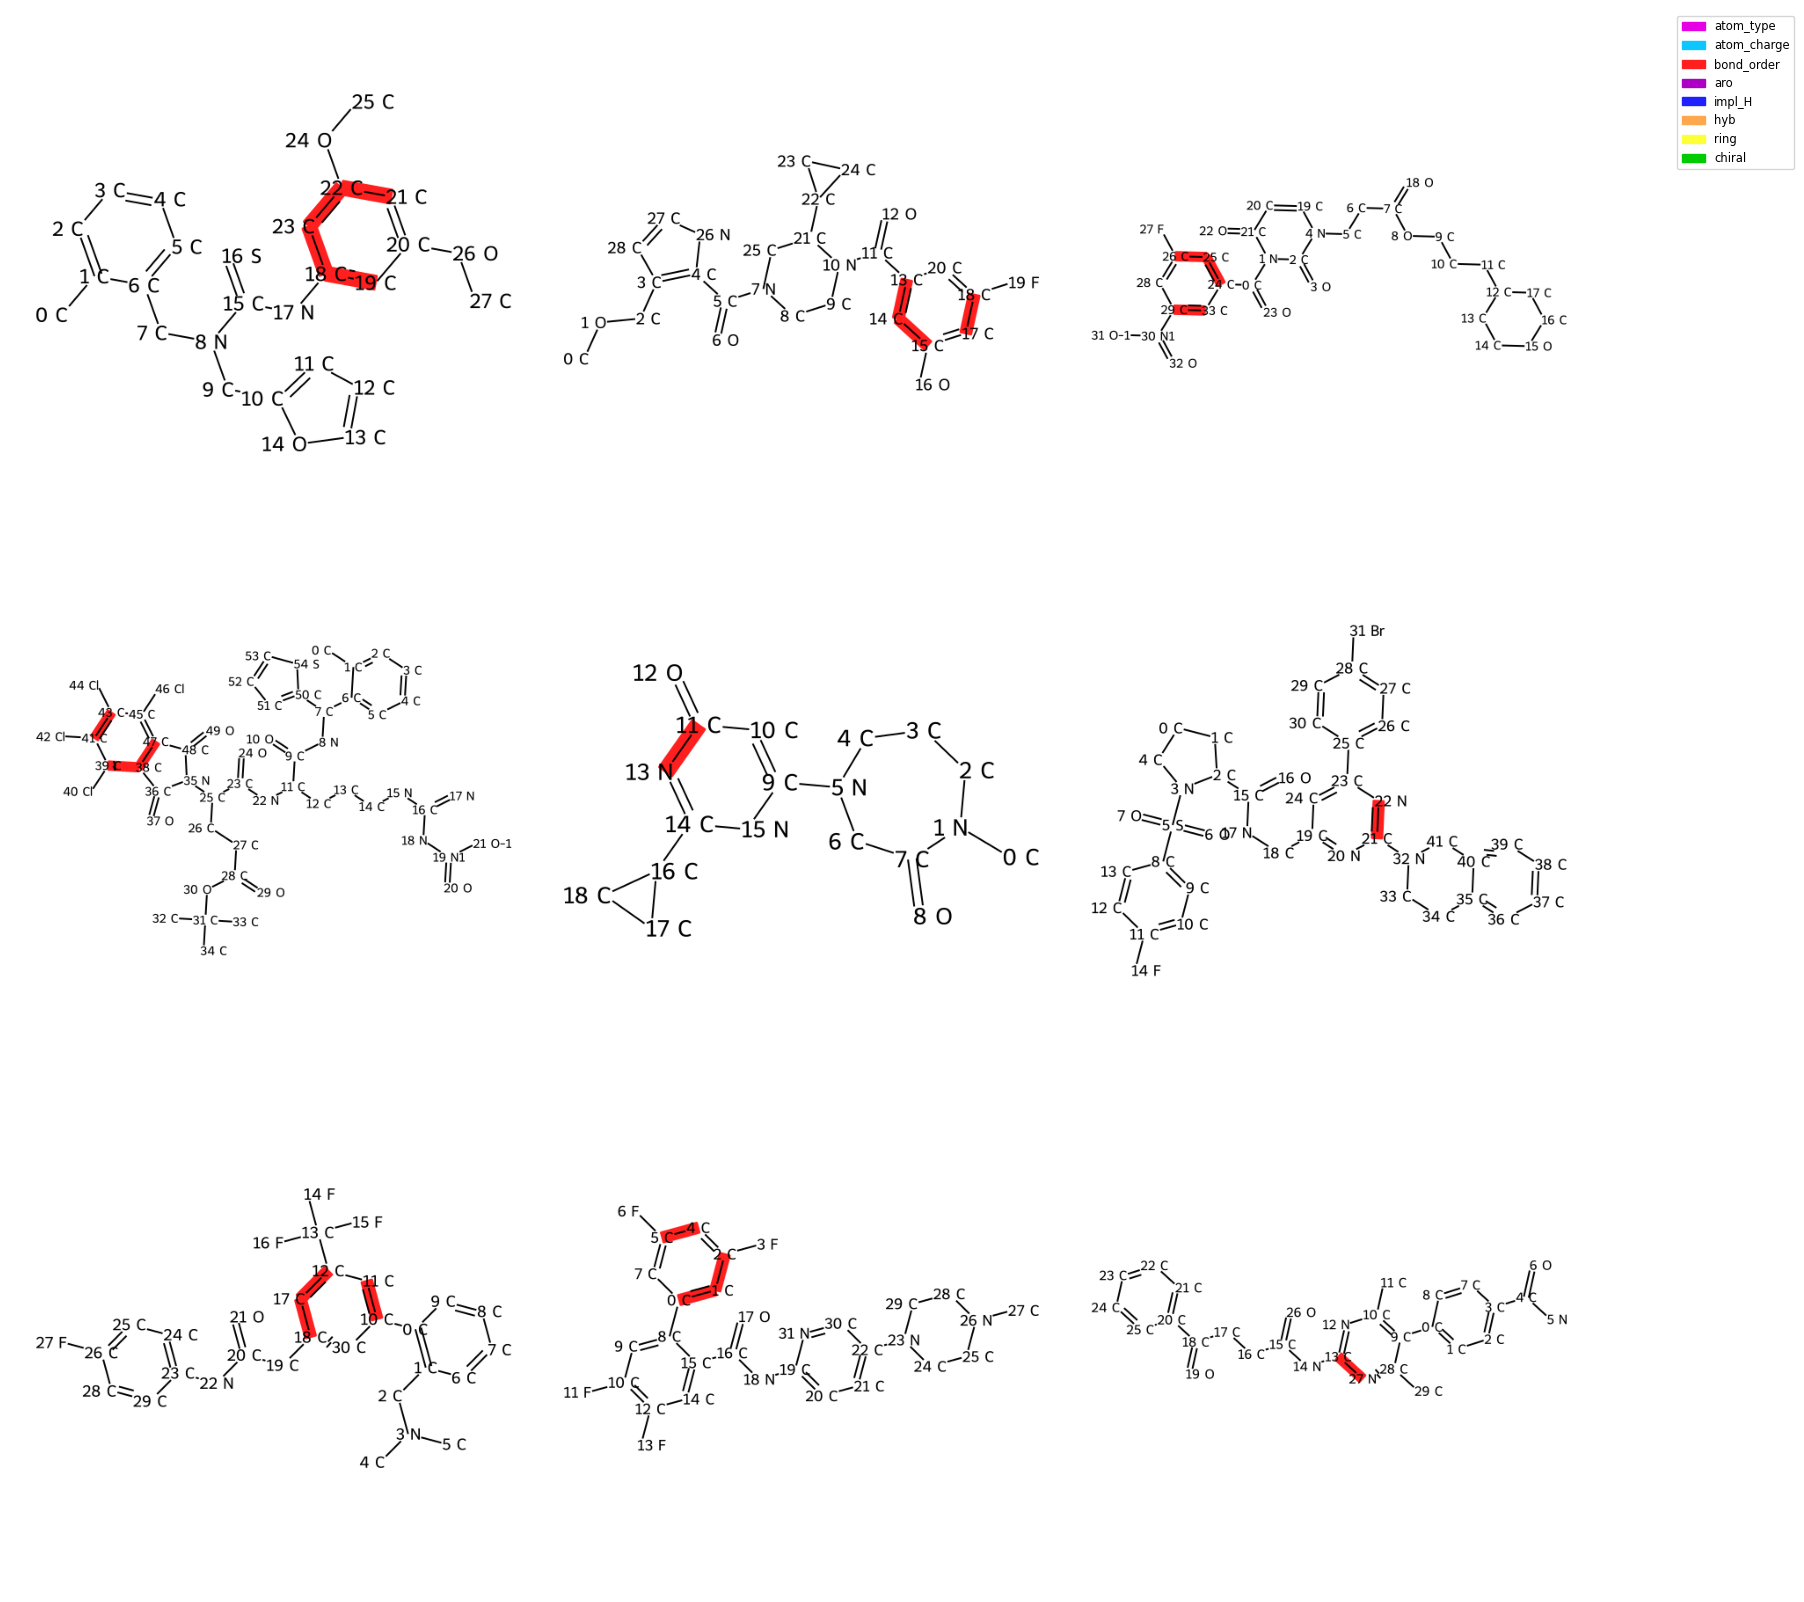

In [31]:
# Display wrongly predicted bond orders
display_performance(model, pharmit_val_dataset, n_mols=9, use_bond_order=True)

## Checking ligand loading

In [7]:
cfg = quick_load.load_cfg(overrides=['task_group=no_protein_extra_feats'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
pharmit_dataset = train_dataset.datasets['pharmit']
g = pharmit_dataset[('denovo_ligand_condensed', 0)]
g.nodes['lig'].data.keys()

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


dict_keys(['x_1_true', 'cond_a_1_true', 'x_0', 'cond_a_0'])

In [2]:
cfg = quick_load.load_cfg(overrides=['task_group=fixed_protein'], plinder_path='/net/galaxy/home/koes/ltoft/OMTRA/data/plinder')
datamodule = datamodule_from_config(cfg)
dataset = datamodule.load_dataset("train")
plinder_dataset = dataset.datasets['plinder']
data = plinder_dataset['no_links']
g = data[('rigid_docking', 0)]
g.nodes['lig'].data.keys()

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


dict_keys(['x_1_true', 'a_1_true', 'c_1_true', 'x_0'])

In [2]:
cfg = quick_load.load_cfg(overrides=['task_group=fixed_protein_cond_a'], plinder_path='/net/galaxy/home/koes/ltoft/OMTRA/data/plinder')
datamodule = datamodule_from_config(cfg)
dataset = datamodule.load_dataset("train")
plinder_dataset = dataset.datasets['plinder']
data = plinder_dataset['no_links']
g = data[('fixed_protein_ligand_denovo_condensed', 0)]
g.nodes['lig'].data.keys()

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


dict_keys(['x_1_true', 'cond_a_1_true', 'x_0', 'cond_a_0'])